# NPP Model Training

This notebook trains a Random Forest model to predict **natural NPP** (Net Primary Productivity in pristine state) from static environmental predictors.

## Key Configuration
- **Spatial CV**: 2° grid blocks with 0.5° buffer exclusion
- **Train/Test Split**: 90/10 by spatial blocks
- **Model**: GEE smileRandomForest (200 trees)
- **Validated Performance**: R² ≈ 0.94 on held-out spatial blocks

In [ ]:
import os
import random

import ee
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

# Initialize Earth Engine
ee.Initialize(project="landler-open-data")

# Asset paths
GEE_ASSET_ROOT = "projects/landler-open-data/assets/eii/intermediate/functional"
TRAINING_ASSET_PATH = f"{GEE_ASSET_ROOT}/training/final_reference_samples"
MODEL_ASSETS_PATH = f"{GEE_ASSET_ROOT}/models"
VALIDATION_ASSET_PATH = f"{GEE_ASSET_ROOT}/validation"

# Output directories
FIGURES_DIR = "../../../analysis/figures/v1"
RESULTS_DIR = "../../../analysis/results/v1"
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"Training data: {TRAINING_ASSET_PATH}")

Training data: projects/landler-open-data/assets/eii/intermediate/functional/training/final_reference_samples


In [ ]:
# Spatial CV settings
CV_GRID_SIZE_DEG = 4  # Size of spatial blocks in degrees
CV_BUFFER_DEG = 1  # Buffer to exclude from block edges
TRAIN_TEST_SPLIT_RATIO = 0.9

# Random Forest hyperparameters
RF_NUM_TREES = 200
RF_MIN_LEAF_POPULATION = 10
RF_VARIABLES_PER_SPLIT = 2
RF_BAG_FRACTION = 0.5
RF_SEED = 42

# Predictor variables
climate = [
    "mean_annual_temp",
    "temp_seasonality",
    "annual_precip",
    "precip_seasonality",
]

aridity = [
    "aridity",
]

elevation = [
    "elevation",
    "slope",
]

terrain = [
    "tpi",
    "tri",
    "cti",
    "northness",
]

terrain_regional = [
    "tpi_regional",
]

soil = [
    "sand",
    "clay",
    #  "ph",
]

location = [
    "latitude",
    "longitude",
]

chelsa = [
    "chelsa_npp",
]


PREDICTOR_VARIABLES = climate + aridity + soil + location + chelsa

# Response variables
RESPONSE_VAR_MEAN = "longterm_avg_npp_sum"
RESPONSE_VAR_STD = "longterm_avg_npp_sd"

print(f"Predictors ({len(PREDICTOR_VARIABLES)}): {PREDICTOR_VARIABLES}")
print(f"Response variables: {RESPONSE_VAR_MEAN}, {RESPONSE_VAR_STD}")

Predictors (10): ['mean_annual_temp', 'temp_seasonality', 'annual_precip', 'precip_seasonality', 'aridity', 'sand', 'clay', 'latitude', 'longitude', 'chelsa_npp']
Response variables: longterm_avg_npp_sum, longterm_avg_npp_sd


## Load Training Data

In [ ]:
training_data = ee.FeatureCollection(TRAINING_ASSET_PATH)
n_samples = training_data.size().getInfo()
print(f"Loaded {n_samples:,} training samples")

# Check available properties
sample_props = training_data.first().propertyNames().getInfo()
print(f"Available properties: {len(sample_props)}")
print(sample_props)

# Verify all predictors are present
missing = [p for p in PREDICTOR_VARIABLES if p not in sample_props]
if missing:
    print(f"WARNING: Missing predictors: {missing}")

Loaded 110,657 training samples
Available properties: 23
['temp_seasonality', 'elevation', 'chelsa_npp', 'annual_precip', 'latitude', 'tri', 'slope', 'tpi', 'clay', 'grid_cell', 'sand', 'eastness', 'northness', 'longterm_avg_npp_sd', 'mean_annual_temp', 'ph', 'longterm_avg_npp_sum', 'aridity', 'cti', 'precip_seasonality', 'tpi_regional', 'system:index', 'longitude']
✓ All predictors available


## Spatially Stratified Train/Test Split

In [14]:
# =============================================================================
# 4. Spatially Stratified Train/Test Split
# =============================================================================


def get_train_test_split(
    data,
    grid_size=CV_GRID_SIZE_DEG,
    buffer_size=CV_BUFFER_DEG,
    split_ratio=TRAIN_TEST_SPLIT_RATIO,
    seed=RF_SEED,
):
    """
    Split data into train/test using spatial blocks.

    Assigns each sample to a grid block based on lat/lon,
    then assigns entire blocks to train or test sets.
    Optionally excludes samples near block edges (buffer).
    """

    def add_block_info(feature):
        coords = feature.geometry().coordinates()
        lon = coords.get(0)
        lat = coords.get(1)

        # Shift to positive range
        lon_shifted = ee.Number(lon).add(180)
        lat_shifted = ee.Number(lat).add(90)

        # Block indices
        x = lon_shifted.divide(grid_size).floor()
        y = lat_shifted.divide(grid_size).floor()

        # Position within block
        x_rel = lon_shifted.mod(grid_size)
        y_rel = lat_shifted.mod(grid_size)

        # Unique block ID
        block_id = y.multiply(1000).add(x).toInt()

        # Check if in inner region (not in buffer)
        inner_cond = (
            x_rel.gte(buffer_size)
            .And(x_rel.lte(ee.Number(grid_size).subtract(buffer_size)))
            .And(y_rel.gte(buffer_size))
            .And(y_rel.lte(ee.Number(grid_size).subtract(buffer_size)))
        )

        return feature.set({"cv_block_id": block_id, "cv_keep": inner_cond})

    # Add block info to all samples
    data_with_blocks = data.map(add_block_info)

    # Filter out buffer samples if buffer > 0
    if buffer_size > 0:
        data_filtered = data_with_blocks.filter(ee.Filter.eq("cv_keep", 1))
    else:
        data_filtered = data_with_blocks

    # Get distinct blocks and shuffle
    blocks = data_filtered.aggregate_array("cv_block_id").distinct().getInfo()
    random.seed(seed)
    random.shuffle(blocks)

    # Split blocks
    split_idx = int(len(blocks) * split_ratio)
    train_blocks = blocks[:split_idx]
    test_blocks = blocks[split_idx:]

    # Create train/test sets
    train_set = data_filtered.filter(ee.Filter.inList("cv_block_id", train_blocks))
    test_set = data_filtered.filter(ee.Filter.inList("cv_block_id", test_blocks))

    return train_set, test_set, len(train_blocks), len(test_blocks)


# Perform split
print(f"Splitting with {CV_GRID_SIZE_DEG}° blocks and {CV_BUFFER_DEG}° buffer...")
training_set, validation_set, n_train_blocks, n_test_blocks = get_train_test_split(training_data)

n_train = training_set.size().getInfo()
n_test = validation_set.size().getInfo()

print(f"\nTrain: {n_train:,} samples in {n_train_blocks} blocks")
print(f"Test:  {n_test:,} samples in {n_test_blocks} blocks")
print(f"Split ratio: {n_train / (n_train + n_test):.1%}")

Splitting with 4° blocks and 1° buffer...

Train: 25,204 samples in 711 blocks
Test:  2,619 samples in 80 blocks
Split ratio: 90.6%


## Train Random Forest Model

In [15]:
POSTFIX = "climate_aridity_soil_location_chelsa_hyper"

In [16]:
# =============================================================================
# 5. Train Random Forest Models (Mean and Std)
# =============================================================================


def train_rf_model(training_data, response_var, model_name):
    """Train a Random Forest model for the given response variable."""
    print(f"\nTraining {model_name} model (response: {response_var})...")

    model = (
        ee.Classifier.smileRandomForest(
            numberOfTrees=RF_NUM_TREES,
            minLeafPopulation=RF_MIN_LEAF_POPULATION,
            variablesPerSplit=2,  # RF_VARIABLES_PER_SPLIT ,
            bagFraction=RF_BAG_FRACTION,
            seed=RF_SEED,
        )
        .setOutputMode("REGRESSION")
        .train(
            features=training_data,
            classProperty=response_var,
            inputProperties=PREDICTOR_VARIABLES,
        )
    )

    model_info = model.explain().getInfo()
    oob_error = model_info.get("outOfBagErrorEstimate", None)
    if oob_error:
        print(f"  OOB RMSE: {np.sqrt(oob_error):,.0f}")
    print(f"  ✓ {model_name} model trained successfully")

    return model, model_info


# Train Mean NPP model
rf_model_mean, model_info_mean = train_rf_model(training_set, RESPONSE_VAR_MEAN, "Mean NPP")

# # Train Std NPP model
rf_model_std, model_info_std = train_rf_model(training_set, RESPONSE_VAR_STD, "Std NPP")


Training Mean NPP model (response: longterm_avg_npp_sum)...
  OOB RMSE: 1,173
  ✓ Mean NPP model trained successfully

Training Std NPP model (response: longterm_avg_npp_sd)...
  OOB RMSE: 42
  ✓ Std NPP model trained successfully


## Variable Importance

=== Mean NPP Model ===


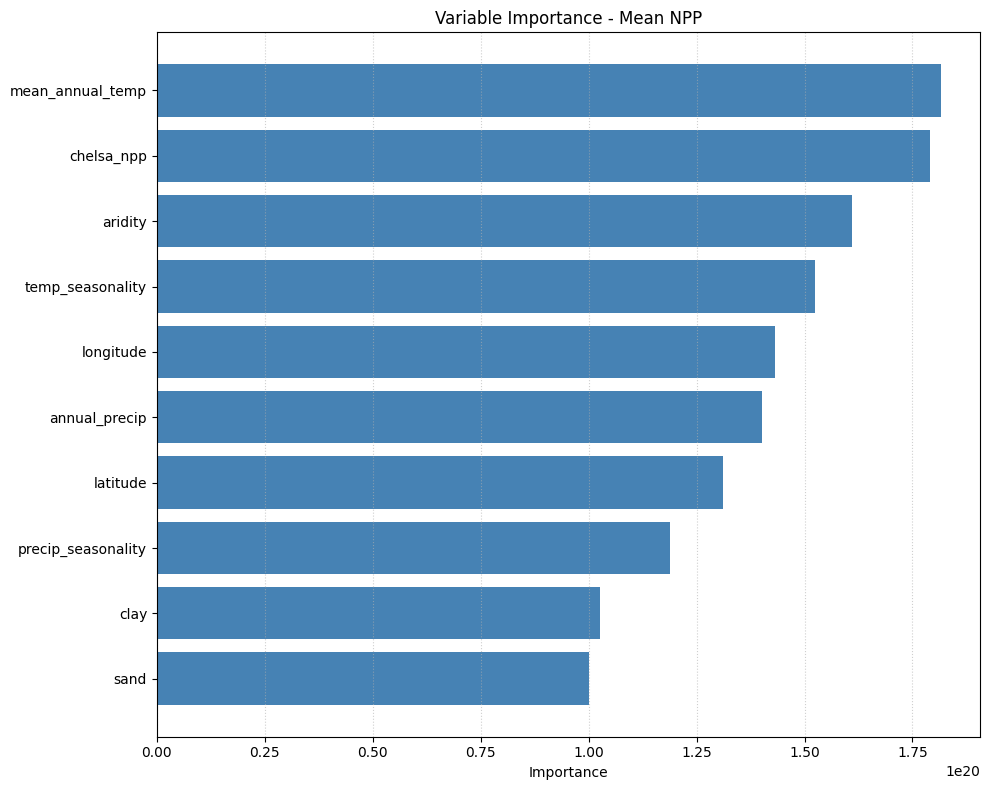


Top 5 predictors (Mean):
  mean_annual_temp: 181555251446651256832.0000
  chelsa_npp: 179128369069168427008.0000
  aridity: 161030874275024666624.0000
  temp_seasonality: 152327177488534700032.0000
  longitude: 143088266736166862848.0000

=== Std NPP Model ===


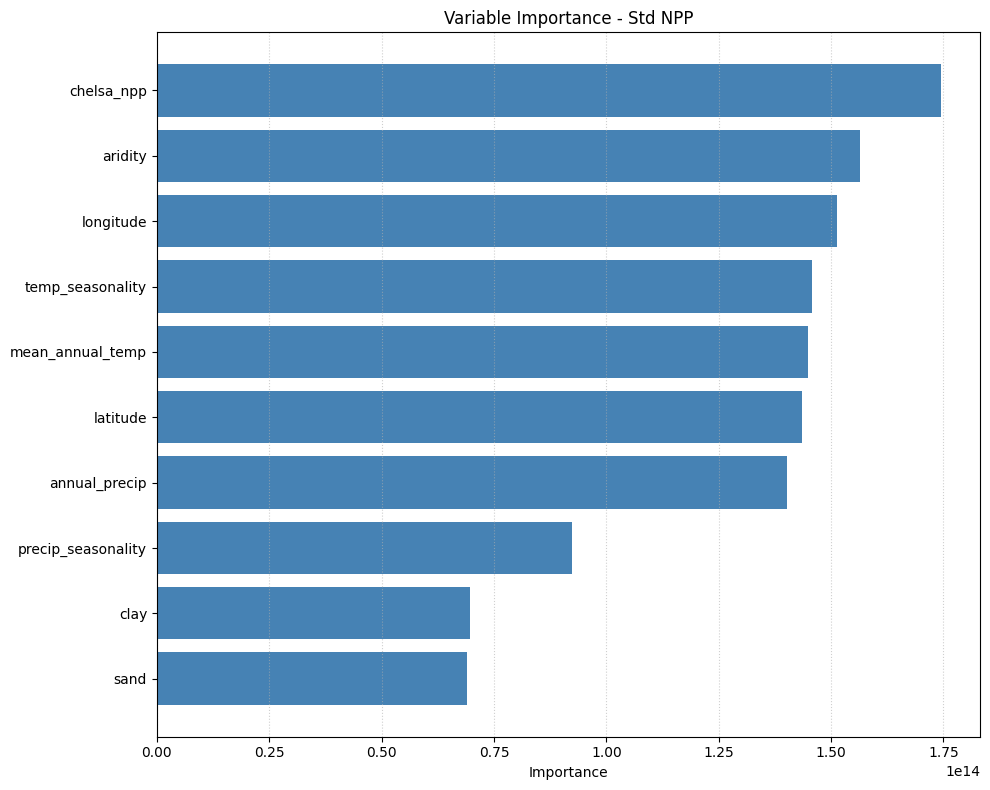


Top 5 predictors (Std):
  chelsa_npp: 174408571589984.0938
  aridity: 156372869779212.8750
  longitude: 151353488787988.4688
  temp_seasonality: 145689661047208.6875
  mean_annual_temp: 144896202438125.7500


In [ ]:
SAVE_RESULTS = True


def plot_variable_importance(model_info, title, filename, save_results=SAVE_RESULTS):
    """Plot and save variable importance for a model."""
    importance = model_info.get("importance", {})
    importance_sorted = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    df_importance = pd.DataFrame(importance_sorted, columns=["Predictor", "Importance"])

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.barh(df_importance["Predictor"], df_importance["Importance"], color="steelblue")
    ax.set_xlabel("Importance")
    ax.set_title(title)
    ax.invert_yaxis()
    ax.grid(axis="x", linestyle=":", alpha=0.6)

    plt.tight_layout()
    if save_results:
        plt.savefig(f"{FIGURES_DIR}/{filename}.png", dpi=300, bbox_inches="tight")
    plt.show()

    if save_results:
        df_importance.to_csv(f"{RESULTS_DIR}/{filename}.csv", index=False)
    return df_importance


# Mean model importance
print("=== Mean NPP Model ===")
df_importance_mean = plot_variable_importance(
    model_info_mean, "Variable Importance - Mean NPP", "variable_importance_mean"
)
print("\nTop 5 predictors (Mean):")
for _, row in df_importance_mean.head().iterrows():
    print(f"  {row['Predictor']}: {row['Importance']:.4f}")

# Std model importance
print("\n=== Std NPP Model ===")
df_importance_std = plot_variable_importance(
    model_info_std, "Variable Importance - Std NPP", "variable_importance_std"
)
print("\nTop 5 predictors (Std):")
for _, row in df_importance_std.head().iterrows():
    print(f"  {row['Predictor']}: {row['Importance']:.4f}")

## Model Validation

In [ ]:
def get_predictions(model, dataset, response_var, dataset_name):
    """Get predictions for a dataset using the given model."""
    predictions = dataset.classify(model, outputName="predicted")
    data = predictions.reduceColumns(
        reducer=ee.Reducer.toList(2), selectors=[response_var, "predicted"]
    ).getInfo()["list"]
    df = pd.DataFrame(data, columns=["actual", "predicted"])
    print(f"  {dataset_name}: {len(df):,} samples")
    return df


print("Generating predictions for Mean NPP model...")
df_train_mean = get_predictions(rf_model_mean, training_set, RESPONSE_VAR_MEAN, "Train")
df_val_mean = get_predictions(rf_model_mean, validation_set, RESPONSE_VAR_MEAN, "Validation")

print("\nGenerating predictions for Std NPP model...")
df_train_std = get_predictions(rf_model_std, training_set, RESPONSE_VAR_STD, "Train")
df_val_std = get_predictions(rf_model_std, validation_set, RESPONSE_VAR_STD, "Validation")

Generating predictions for Mean NPP model...
  Train: 25,204 samples
  Validation: 2,619 samples

Generating predictions for Std NPP model...
  Train: 25,204 samples
  Validation: 2,619 samples


In [ ]:
def calc_metrics(df, name):
    """Calculate regression metrics."""
    r2 = r2_score(df["actual"], df["predicted"])
    rmse = np.sqrt(mean_squared_error(df["actual"], df["predicted"]))
    mae = np.abs(df["actual"] - df["predicted"]).mean()
    bias = (df["predicted"] - df["actual"]).mean()
    return {"Set": name, "R²": r2, "RMSE": rmse, "MAE": mae, "Bias": bias, "N": len(df)}


metrics_mean = pd.DataFrame(
    [calc_metrics(df_train_mean, "Training"), calc_metrics(df_val_mean, "Validation")]
)
print("MEAN NPP MODEL PERFORMANCE")
print(metrics_mean.to_string(index=False))
if SAVE_RESULTS:
    metrics_mean.to_csv(f"{RESULTS_DIR}/model_metrics_mean.csv", index=False)

metrics_std = pd.DataFrame(
    [calc_metrics(df_train_std, "Training"), calc_metrics(df_val_std, "Validation")]
)
print("STD NPP MODEL PERFORMANCE")
print(metrics_std.to_string(index=False))
if SAVE_RESULTS:
    metrics_std.to_csv(f"{RESULTS_DIR}/model_metrics_std.csv", index=False)

# Dump metrics
r2_val_mean2_train_mean = r2_score(df_train_mean["actual"], df_train_mean["predicted"])
r2_val_mean = r2_score(df_val_mean["actual"], df_val_mean["predicted"])
rmse_val_mean = np.sqrt(mean_squared_error(df_val_mean["actual"], df_val_mean["predicted"]))

r2_train_std = r2_score(df_train_std["actual"], df_train_std["predicted"])
r2_val_std = r2_score(df_val_std["actual"], df_val_std["predicted"])
rmse_val_std = np.sqrt(mean_squared_error(df_val_std["actual"], df_val_std["predicted"]))


MEAN NPP MODEL PERFORMANCE
       Set       R²         RMSE           MAE          Bias    N
Validation 0.919111 1.619948e+06 866002.445867 -92401.125906 2619

STD NPP MODEL PERFORMANCE
       Set       R²        RMSE         MAE        Bias    N
Validation 0.803454 2412.476129 1357.870121 -149.715687 2619


=== Mean NPP Model ===


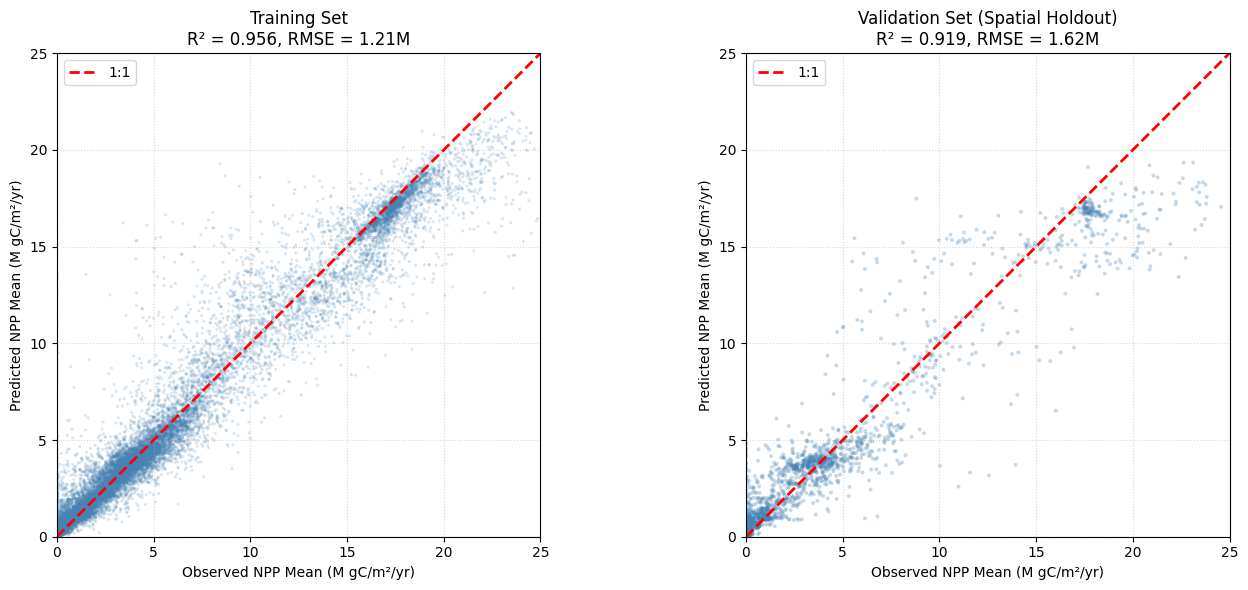


=== Std NPP Model ===


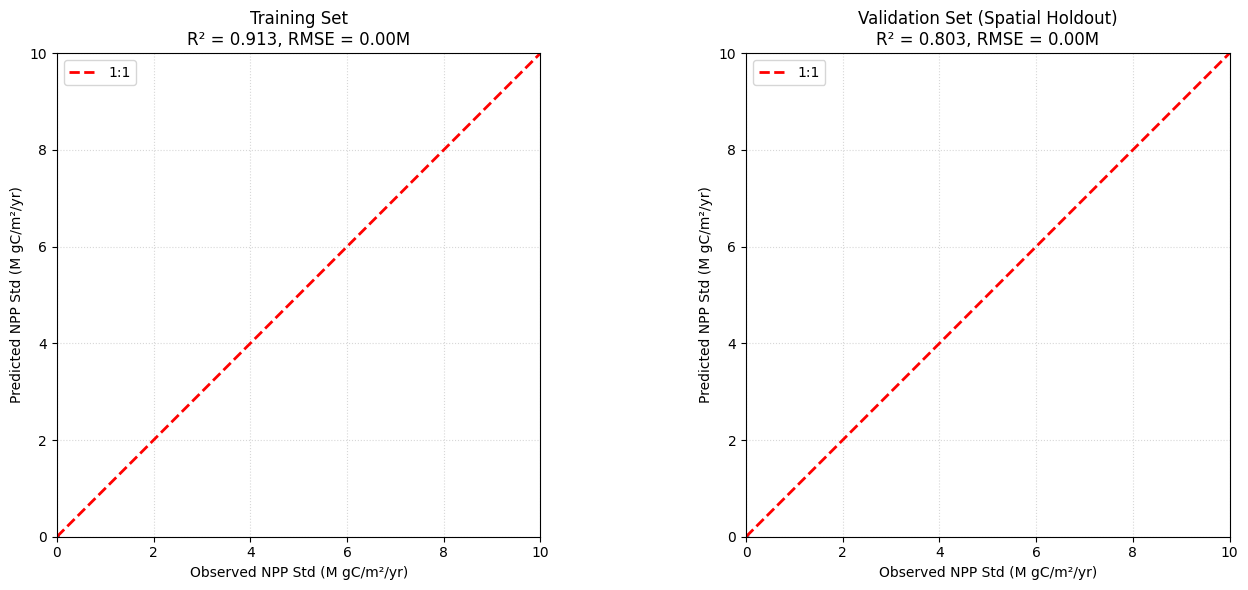

In [ ]:
def plot_scatter_validation(df_train, df_val, title_prefix, filename, scale=1e6, xlim=25):
    """Plot scatter plots for train and validation sets."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    r2_train = r2_score(df_train["actual"], df_train["predicted"])
    r2_val = r2_score(df_val["actual"], df_val["predicted"])
    rmse_train = np.sqrt(mean_squared_error(df_train["actual"], df_train["predicted"]))
    rmse_val = np.sqrt(mean_squared_error(df_val["actual"], df_val["predicted"]))

    # Training
    ax = axes[0]
    ax.scatter(
        df_train["actual"] / scale,
        df_train["predicted"] / scale,
        alpha=0.2,
        s=5,
        c="steelblue",
        edgecolors="none",
    )
    ax.plot([0, xlim], [0, xlim], "r--", lw=2, label="1:1")
    ax.set_xlabel(f"Observed {title_prefix}")
    ax.set_ylabel(f"Predicted {title_prefix}")
    ax.set_title(f"Training Set\nR² = {r2_train:.3f}, RMSE = {rmse_train / scale:.2f}M")
    ax.set_xlim(0, xlim)
    ax.set_ylim(0, xlim)
    ax.set_aspect("equal")
    ax.grid(True, linestyle=":", alpha=0.5)
    ax.legend()

    # Validation
    ax = axes[1]
    ax.scatter(
        df_val["actual"] / scale,
        df_val["predicted"] / scale,
        alpha=0.3,
        s=8,
        c="steelblue",
        edgecolors="none",
    )
    ax.plot([0, xlim], [0, xlim], "r--", lw=2, label="1:1")
    ax.set_xlabel(f"Observed {title_prefix}")
    ax.set_ylabel(f"Predicted {title_prefix}")
    ax.set_title(
        f"Validation Set (Spatial Holdout)\nR² = {r2_val:.3f}, RMSE = {rmse_val / scale:.2f}M"
    )
    ax.set_xlim(0, xlim)
    ax.set_ylim(0, xlim)
    ax.set_aspect("equal")
    ax.grid(True, linestyle=":", alpha=0.5)
    ax.legend()

    plt.tight_layout()
    plt.savefig(f"{FIGURES_DIR}/{filename}.png", dpi=300, bbox_inches="tight")
    plt.show()


# Mean NPP scatter plots
print("=== Mean NPP Model ===")
plot_scatter_validation(
    df_train_mean,
    df_val_mean,
    "NPP Mean (M gC/m²/yr)",
    "validation_scatter_mean",
    scale=1e6,
    xlim=25,
)

# Std NPP scatter plots
print("\n=== Std NPP Model ===")
plot_scatter_validation(
    df_train_std, df_val_std, "NPP Std (M gC/m²/yr)", "validation_scatter_std", scale=1e6, xlim=10
)

=== Mean NPP Model Residuals ===


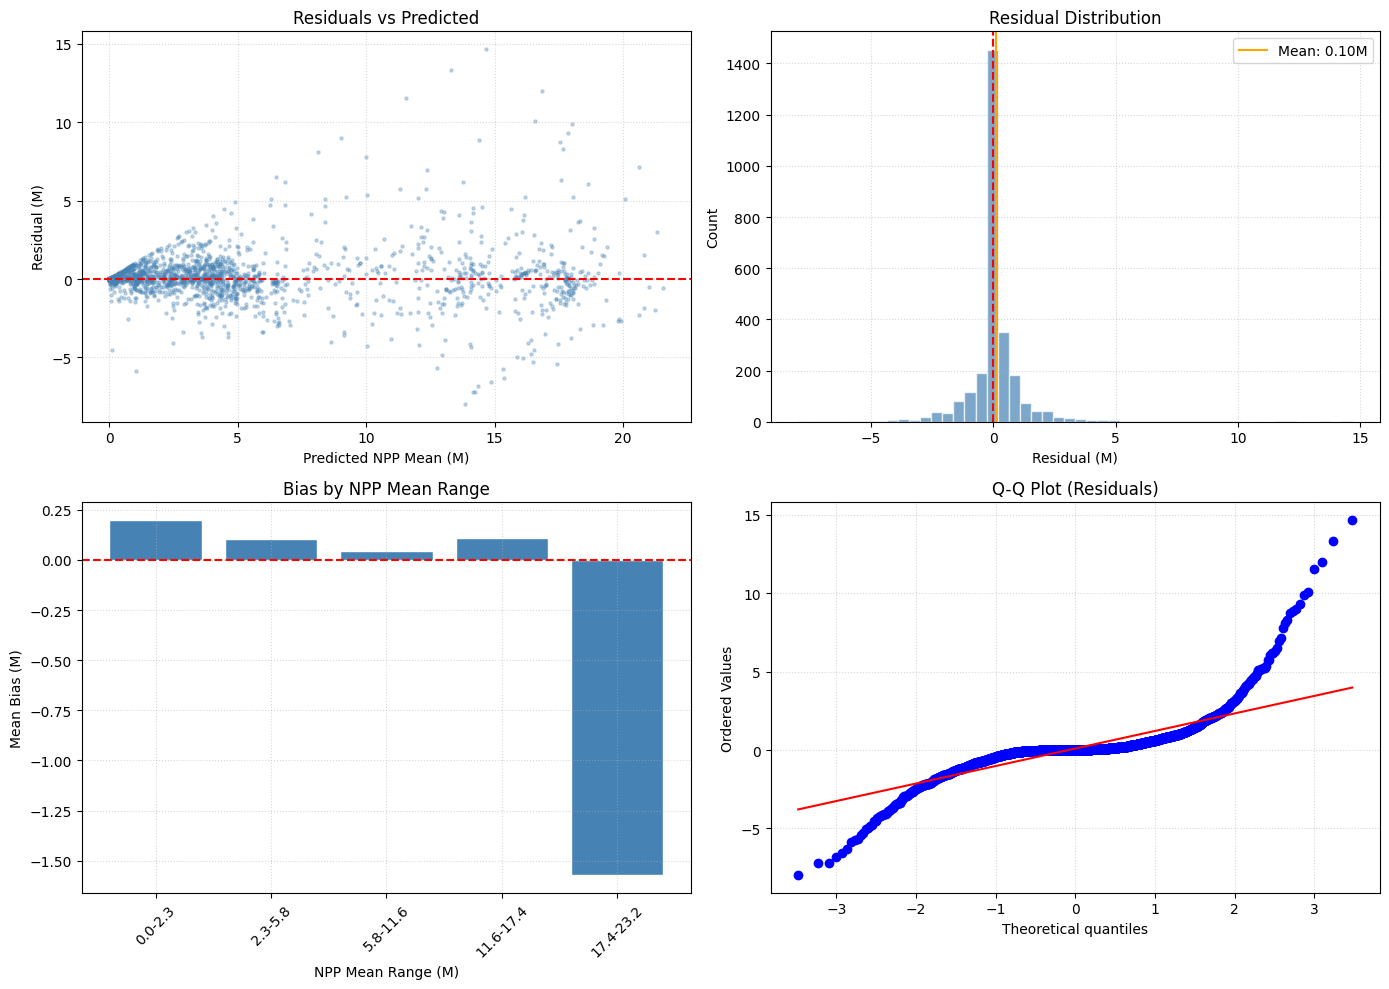


=== Std NPP Model Residuals ===


ValueError: labels must be unique if ordered=True; pass ordered=False for duplicate labels

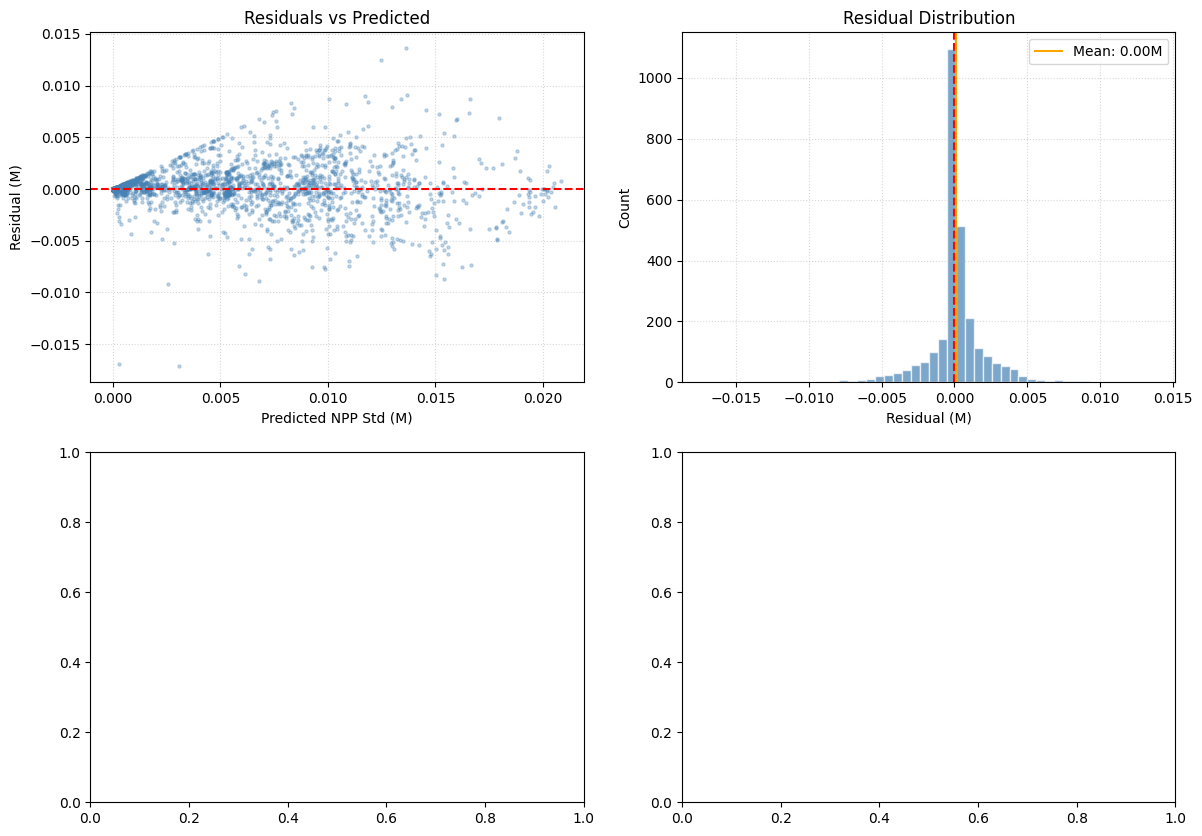

In [ ]:
def plot_residual_analysis(df_val, title_prefix, filename, scale=1e6):
    """Plot residual analysis for a model."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    residuals = df_val["predicted"] - df_val["actual"]

    # Residuals vs Predicted
    ax = axes[0, 0]
    ax.scatter(df_val["predicted"] / scale, residuals / scale, alpha=0.3, s=5, c="steelblue")
    ax.axhline(0, color="red", linestyle="--", lw=1.5)
    ax.set_xlabel(f"Predicted {title_prefix} (M)")
    ax.set_ylabel("Residual (M)")
    ax.set_title("Residuals vs Predicted")
    ax.grid(True, linestyle=":", alpha=0.5)

    # Residual Distribution
    ax = axes[0, 1]
    ax.hist(residuals / scale, bins=50, color="steelblue", edgecolor="white", alpha=0.7)
    ax.axvline(0, color="red", linestyle="--", lw=1.5)
    ax.axvline(
        residuals.mean() / scale,
        color="orange",
        linestyle="-",
        lw=1.5,
        label=f"Mean: {residuals.mean() / scale:.2f}M",
    )
    ax.set_xlabel("Residual (M)")
    ax.set_ylabel("Count")
    ax.set_title("Residual Distribution")
    ax.legend()
    ax.grid(True, linestyle=":", alpha=0.5)

    # Bias by value range
    ax = axes[1, 0]
    df_temp = df_val.copy()
    df_temp["residual"] = residuals
    max_val = df_val["actual"].max() / scale
    bins = [0, max_val * 0.1, max_val * 0.25, max_val * 0.5, max_val * 0.75, max_val]
    labels = [f"{bins[i]:.1f}-{bins[i + 1]:.1f}" for i in range(len(bins) - 1)]
    df_temp["val_bin"] = pd.cut(df_temp["actual"] / scale, bins=bins, labels=labels)
    bias_by_bin = df_temp.groupby("val_bin", observed=True)["residual"].mean() / scale
    ax.bar(bias_by_bin.index.astype(str), bias_by_bin.values, color="steelblue", edgecolor="white")
    ax.axhline(0, color="red", linestyle="--", lw=1.5)
    ax.set_xlabel(f"{title_prefix} Range (M)")
    ax.set_ylabel("Mean Bias (M)")
    ax.set_title(f"Bias by {title_prefix} Range")
    ax.tick_params(axis="x", rotation=45)
    ax.grid(True, linestyle=":", alpha=0.5)

    # QQ
    ax = axes[1, 1]
    from scipy import stats

    stats.probplot(residuals / scale, dist="norm", plot=ax)
    ax.set_title("Q-Q Plot (Residuals)")
    ax.grid(True, linestyle=":", alpha=0.5)

    plt.tight_layout()
    plt.savefig(f"{FIGURES_DIR}/{filename}.png", dpi=300, bbox_inches="tight")
    plt.show()


# Mean NPP residual analysis
print("=== Mean NPP Model Residuals ===")
plot_residual_analysis(df_val_mean, "NPP Mean", "residual_analysis_mean")

# Std NPP residual analysis
print("\n=== Std NPP Model Residuals ===")
plot_residual_analysis(df_val_std, "NPP Std", "residual_analysis_std")

## Export Model

In [ ]:
model_asset_path_mean = f"{MODEL_ASSETS_PATH}/npp_rf_model_mean_{NPP_MODEL_VERSION}_{POSTFIX}"
model_asset_path_std = f"{MODEL_ASSETS_PATH}/npp_rf_model_std_{NPP_MODEL_VERSION}_{POSTFIX}"

print(f"Exporting Mean NPP model to: {model_asset_path_mean}")
export_task_mean = ee.batch.Export.classifier.toAsset(
    classifier=rf_model_mean,
    description="Export_NPP_RF_Model_Mean",
    assetId=model_asset_path_mean,
)
export_task_mean.start()

print(f"Exporting Std NPP model to: {model_asset_path_std}")
export_task_std = ee.batch.Export.classifier.toAsset(
    classifier=rf_model_std,
    description="Export_NPP_RF_Model_Std",
    assetId=model_asset_path_std,
)
export_task_std.start()

Exporting Mean NPP model to: projects/landler-open-data/assets/eii/intermediate/functional/models/npp_rf_model_mean_v1_climate_aridity_soil_location_chelsa_hyper
Exporting Std NPP model to: projects/landler-open-data/assets/eii/intermediate/functional/models/npp_rf_model_std_v1_climate_aridity_soil_location_chelsa_hyper

Export tasks started for both models.


In [ ]:
export_task_mean.status(), export_task_std.status()

## Summary

In [ ]:
print("\n" + "=" * 70)
print("NPP MODEL TRAINING SUMMARY")
print("=" * 70)
print("")
print(f"Training samples:    {n_train:,}")
print(f"Validation samples:  {n_test:,}")
print(f"Predictors:          {len(PREDICTOR_VARIABLES)}")
print("")
print(f"Spatial CV:          {CV_GRID_SIZE_DEG}° blocks, {CV_BUFFER_DEG}° buffer")
print(f"RF Parameters:       {RF_NUM_TREES} trees, {RF_MIN_LEAF_POPULATION} min leaf")
print("")
print("-" * 70)
print("MEAN NPP MODEL")
print("-" * 70)
print(f"  Training R²:       {r2_train_mean:.4f}")
print(f"  Validation R²:     {r2_val_mean:.4f}")
print(f"  Validation RMSE:   {rmse_val_mean / 1e6:.2f} M gC/m²/yr")
print(f"  Exported to:       {model_asset_path_mean}")
print("")
print("-" * 70)
print("STD NPP MODEL")
print("-" * 70)
print(f"  Training R²:       {r2_train_std:.4f}")
print(f"  Validation R²:     {r2_val_std:.4f}")
print(f"  Validation RMSE:   {rmse_val_std / 1e6:.2f} M gC/m²/yr")
print(f"  Exported to:       {model_asset_path_std}")
print("=" * 70)


NPP MODEL TRAINING SUMMARY

Training samples:    25,116
Validation samples:  2,750
Predictors:          15

Spatial CV:          2° blocks, 0.5° buffer
RF Parameters:       200 trees, 5 min leaf

----------------------------------------------------------------------
MEAN NPP MODEL
----------------------------------------------------------------------
  Training R²:       0.9820
  Validation R²:     0.9438
  Validation RMSE:   1.29 M gC/m²/yr
  Exported to:       projects/landler-open-data/assets/eii/intermediate/functional/models/npp_rf_model_mean_v1

----------------------------------------------------------------------
STD NPP MODEL
----------------------------------------------------------------------
  Training R²:       0.9593
  Validation R²:     0.8561
  Validation RMSE:   0.00 M gC/m²/yr
  Exported to:       projects/landler-open-data/assets/eii/intermediate/functional/models/npp_rf_model_std_v1
